In [39]:
import numpy as np

from scipy.optimize import curve_fit
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.dagcircuit import DAGCircuit, DAGNode, DAGOpNode

import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 16})  # enlarge matplotlib fonts

from tqdm import tqdm
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit.opflow import Zero, One, I, X, Y, Z, SummedOp, PauliOp
from qiskit.circuit import Parameter, ParameterVector
from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit_nature.mappers.second_quantization import JordanWignerMapper

### Declare parameters

In [40]:
def compute_H_secondquant_normal(eps, tc, t, delta):
    second_quant_H = 0
    second_quant_H += eps[0] * ( FermionicOp("+_{}".format(0)) @ FermionicOp("-_{}".format(0)))
    second_quant_H += eps[1] * ( FermionicOp("+_{}".format(1)) @ FermionicOp("-_{}".format(1)))    
    second_quant_H += t[0] * (FermionicOp("+_{}".format(0)) @ FermionicOp("-_{}".format(1)))
    second_quant_H += np.conjugate(t[0]) * (FermionicOp("+_{}".format(1)) @ FermionicOp("-_{}".format(0)))
    second_quant_H += delta[0] * (FermionicOp("+_{}".format(0)) @ FermionicOp("+_{}".format(1)))
    second_quant_H += np.conjugate(delta[0]) * (FermionicOp("-_{}".format(1)) @ FermionicOp("-_{}".format(0)))

    second_quant_H += tc * (FermionicOp("+_{}".format(1)) @ FermionicOp("-_{}".format(2)))
    second_quant_H += tc * (FermionicOp("+_{}".format(2)) @ FermionicOp("-_{}".format(1)))

    second_quant_H += eps[2] * ( FermionicOp("+_{}".format(2)) @ FermionicOp("-_{}".format(2)))
    second_quant_H += eps[3] * ( FermionicOp("+_{}".format(3)) @ FermionicOp("-_{}".format(3)))
    second_quant_H += t[1] * (FermionicOp("+_{}".format(2)) @ FermionicOp("-_{}".format(3)))
    second_quant_H += np.conjugate(t[1]) * (FermionicOp("+_{}".format(3)) @ FermionicOp("-_{}".format(2)))
    second_quant_H += delta[1] * (FermionicOp("+_{}".format(2)) @ FermionicOp("+_{}".format(3)))
    second_quant_H += np.conjugate(delta[1]) * (FermionicOp("-_{}".format(3)) @ FermionicOp("-_{}".format(2)))

    # Transform to Pauli Operators
    jw_mapper = JordanWignerMapper
    pauli_H = JordanWignerMapper.map(jw_mapper, second_quant_H)

    return pauli_H

#H = compute_H_secondquant_normal(1, 0.5, 1, 2)

#### Compute Hamiltonian in Little Endian Notation

In [41]:
def compute_H(eps, t, delta, tc, phiL, phiR, num_sites):
    H = 0
    # On-site terms
    H += eps / 2 * ((I ^ I ^ I ^I ) - (I ^ I ^ I ^ Z))
    H += eps / 2 * ((I ^ I ^ I ^I ) - (I ^ I ^ Z ^ I))

    H += t / 2 * ((I ^ I ^ X ^ X) + (I ^ I ^ Y ^ Y))
    H += delta / 2 * np.cos(phiL)*((I ^ I ^ X ^ X) - (I ^ I ^ Y ^ Y))
    H += delta / 2 * np.sin(phiL)*((I ^ I ^ X ^ X) + (I ^ I ^ Y ^ Y))

    H += tc / 2 * ((I ^ X ^ X ^ I) + (I ^ Y ^ Y ^ I))

    H += eps / 2 * ((I ^ I ^ I ^ I ) - (I ^ Z ^ I ^ I))
    H += eps / 2 * ((I ^ I ^ I ^ I ) - (Z ^ I ^ I ^ I))
    H += t / 2 * ((X ^ X ^ I ^ I) + (Y ^ Y ^ I ^ I))
    H += delta / 2 * np.cos(phiR)*((X ^ X ^ I ^ I) - (Y ^ Y ^ I ^ I))
    H += delta / 2 * np.sin(phiR)*((X ^ X ^ I ^ I) + (Y ^ Y ^ I ^ I))

    return H

# Parameterized hopping strengths
num_sites = 4
eps_param = Parameter("ε")
t_param = Parameter("t")
tc_param = Parameter("tc")
delta_param = Parameter("Δ")
phiR_param = Parameter("phiR")
phiL_param = Parameter("phiL")

H_param = compute_H(eps_param, t_param, delta_param, tc_param, phiL_param, phiR_param, num_sites)
H = H_param.bind_parameters({eps_param: 1, t_param: 1, delta_param: 2, tc_param: 0.5, phiL_param: -0/2, phiR_param: +0 /2})

### Classical simulation Number operator

In [59]:
from functions import exact_time_evolution
#Parameters for simulation
time_max = 4
times = np.linspace(0, time_max * np.pi, 500)

n_is = [
    1 / 2 * ((I ^ num_sites) - ((I ^ i) ^ Z ^ (I ^ (num_sites - i - 1))))
    for i in range(num_sites)
]

initial_state = One ^ One ^ One ^ One
initial_state_str = '1111'
tc = 0.5

# Plot the time evolution
phi = 0
H_1 = H_param.bind_parameters({eps_param: 0, t_param: 1, delta_param: 1, tc_param: tc, phiL_param: -phi / 2, phiR_param: phi / 2})
H_2 = H_param.bind_parameters({eps_param: 1, t_param: 1, delta_param: 2, tc_param: tc, phiL_param: -phi / 2, phiR_param: phi / 2})
H_3 = H_param.bind_parameters({eps_param: 1, t_param: 1, delta_param: 0.5, tc_param: tc, phiL_param: -phi / 2, phiR_param: phi / 2})

n_H1_evo_matrix_state_1, n_var_matrix = exact_time_evolution(H_1, n_is, initial_state, times, num_sites)
n_H2_evo_matrix_state_1, n_var_matrix = exact_time_evolution(H_2, n_is, initial_state, times, num_sites)
n_H3_evo_matrix_state_1, n_var_matrix = exact_time_evolution(H_2, n_is, initial_state, times, num_sites)

# Plot the time evolution
phi = np.pi
H_4 = H_param.bind_parameters({eps_param: 0, t_param: 1, delta_param: 1, tc_param: tc, phiL_param: -phi / 2, phiR_param: phi / 2})
H_5 = H_param.bind_parameters({eps_param: 1, t_param: 1, delta_param: 2, tc_param: tc, phiL_param: -phi / 2, phiR_param: phi / 2})
H_6 = H_param.bind_parameters({eps_param: 1, t_param: 1, delta_param: 0.5, tc_param: tc, phiL_param: -phi / 2, phiR_param: phi / 2})
n_H4_evo_matrix_state_1, n_var_matrix = exact_time_evolution(H_4, n_is, initial_state, times, num_sites)
n_H5_evo_matrix_state_1, n_var_matrix = exact_time_evolution(H_5, n_is, initial_state, times, num_sites)
n_H6_evo_matrix_state_1, n_var_matrix = exact_time_evolution(H_6, n_is, initial_state, times, num_sites)

100%|██████████| 500/500 [01:05<00:00,  7.63it/s]


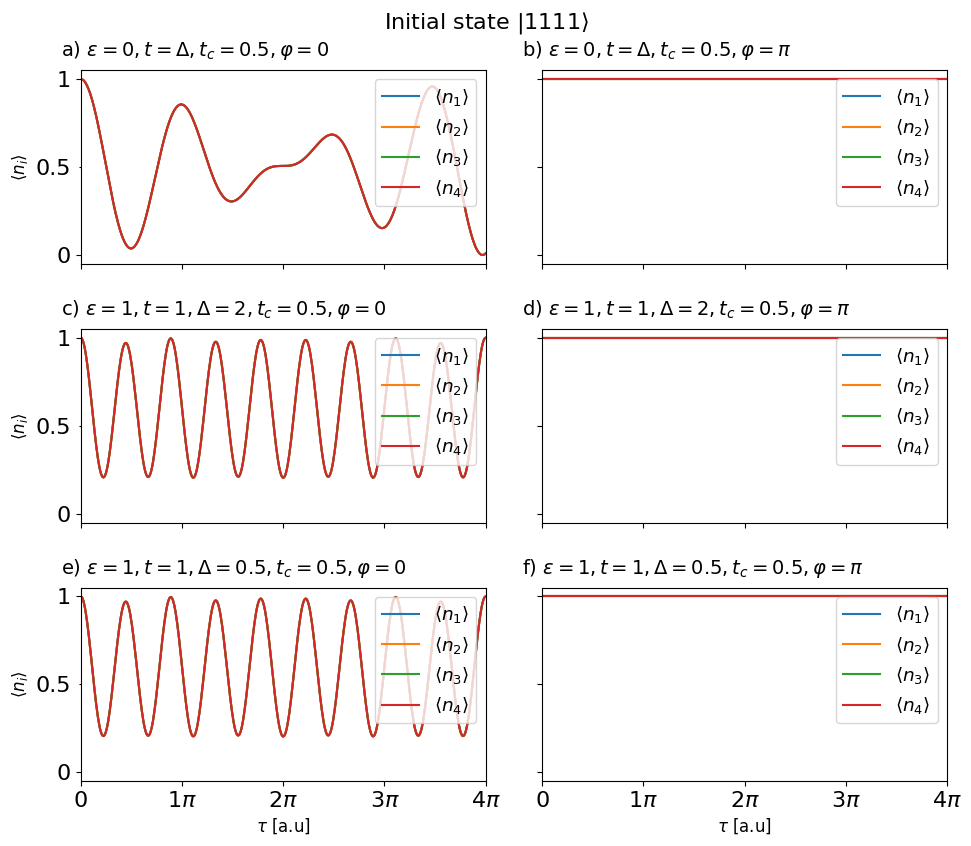

In [60]:
num_op_labels = [rf"$\langle n_{i+1} \rangle$" for i in range(num_sites)]
xticks = np.linspace(0, time_max * np.pi, time_max + 1)
xtick_labels = [r'${}\pi$'.format(i) if i != 0 else '0' for i in range(time_max + 1)]
yticks = [0, 0.5, 1.0]
ytick_labels = ['0', '0.5', '1'] # Changed '' to '0.5' for clarity, adjust if needed

# --- Create 3x2 Subplot Grid ---
fig, axs = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)

# --- Main Figure Title ---
fig.suptitle(r"Initial state $|" + initial_state_str + r"\rangle$", fontsize=16, y=0.88) # Adjusted y for better spacing

# --- Plotting Data ---
# Column 1: phi = 0
axs[0, 0].plot(times, n_H1_evo_matrix_state_1) # eps=0, t=Delta (H_2)
axs[1, 0].plot(times, n_H2_evo_matrix_state_1) # eps=1, t=1, Delta=2 (H_1)
axs[2, 0].plot(times, n_H3_evo_matrix_state_1) # eps=1, t=1, Delta=2 (H_1)

# Column 2: phi = pi
axs[0, 1].plot(times, n_H4_evo_matrix_state_1) # eps=0, t=Delta (H_5)
axs[1, 1].plot(times, n_H5_evo_matrix_state_1) # eps=1, t=1, Delta=2 (H_4)
axs[2, 1].plot(times, n_H6_evo_matrix_state_1) # eps=1, t=1, Delta=2 (H_1)

# --- Row & Corner Labels ---
corner_labels = [[rf'a) $\varepsilon = 0, t=\Delta, t_c = {tc}, \varphi = 0 $', rf'b) $\varepsilon = 0, t=\Delta, t_c = {tc}, \varphi = \pi$'],
                 [rf'c) $\varepsilon = 1, t=1, \Delta = 2, t_c = {tc}, \varphi = 0$', rf'd) $\varepsilon = 1, t=1, \Delta = 2, t_c = {tc}, \varphi = \pi$'],
                 [rf'e) $\varepsilon = 1, t=1, \Delta = 0.5, t_c = {tc}, \varphi = 0$', rf'f) $\varepsilon = 1, t=1, \Delta = 0.5, t_c = {tc}, \varphi = \pi$']]

for r in range(axs.shape[0]): # Iterate through rows (0, 1, 2)
    axs[r, 0].set_ylabel(rf"$\langle n_i \rangle$", fontsize=12) # Set Y-label for the first plot in each row

    # Set X-label for plots in the last row (axs[2,0] and axs[2,1])
    # The original error occurred because 'r' went up to 2, causing axs[2,2]
    # This condition ensures 'r' is used as a column index (0 or 1) for the last row's x-labels
    if r < axs.shape[1]: # axs.shape[1] is the number of columns (2)
        axs[axs.shape[0]-1, r].set_xlabel(rf"$\tau$ [a.u]", fontsize=12)

    for c in range(axs.shape[1]): # Iterate through columns (0, 1)
        axs[r, c].text(-0.05, 1.16, corner_labels[r][c], transform=axs[r, c].transAxes,
                       fontsize=14, va='top', ha='left') # Adjusted y for text
        axs[r, c].legend(num_op_labels, loc='upper right', fontsize='small')
        
# --- General Formatting for all Subplots ---
for ax in axs.flat:
    ax.set_xlim(0, time_max * np.pi)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)

# Set tick labels only on the outer plots
# With sharex=True and sharey=True, Matplotlib often handles this automatically.
# Explicitly setting them gives you more control.
for ax in axs[axs.shape[0]-1, :]:  # Corrected to select the actual bottom row (row index 2 for 3 rows)
    ax.set_xticklabels(xtick_labels)
for ax in axs[:, 0]:  # Left column
    ax.set_yticklabels(ytick_labels)

# --- Customize Y-Tick Length ---
default_tick_length = plt.rcParams['ytick.major.size']
for ax in axs[:, 0]: # For plots in the first column
    y_ticks_list = ax.yaxis.get_major_ticks()
    for tick in y_ticks_list:
        if np.isclose(tick.get_loc(), 0.5): # Check location against your yticks array
            tick.tick1line.set_markersize(default_tick_length / 2)
            tick.tick2line.set_markersize(default_tick_length / 2)

# --- Final Figure Adjustments ---
plt.tight_layout(rect=[0, 0.03, 1, 0.93]) # Adjusted top of rect for suptitle

plt.savefig(f'figures/JJ-kitaev/site-prob-multi_tc={tc}_{initial_state_str}.pdf') # Uncomment to save

# --- Display the plot ---
plt.show()

### Trotterization

In [64]:
# Time evolution calculation using same parameters as the exact classical calculation
from functions import trotter_evolution
from functions import exact_time_evolution
times = np.linspace(0, 8 * np.pi, 500)
n_is = [
    1 / 2 * ((I ^ num_sites) - ((I ^ i) ^ Z ^ (I ^ (num_sites - i - 1))))
    for i in range(num_sites)
]
# Number of trotter steps
tc = 0.5
phi = 0
H_error = H_param.bind_parameters({eps_param: 0, t_param: 1, delta_param: 1, tc_param: tc, phiL_param: -phi / 2, phiR_param: phi / 2})

initial_state = One ^ Zero ^ One ^ Zero #(1 / np.sqrt(3))*(One ^ Zero ^ Zero) + (1 / np.sqrt(3))*(Zero ^ One ^ Zero) + (1 / np.sqrt(2))*(Zero ^ Zero ^ One)

trotter_steps_1 = 2
evo_matrix_trot_1 = trotter_evolution(H_error, n_is, initial_state, times, num_sites, trotter_steps_1)
# trotter_steps_2 = 5
# evo_matrix_trot_2 = trotter_evolution(H, n_is, initial_state, times, num_sites, trotter_steps_2)
trotter_steps_3 = 8
evo_matrix_trot_3 = trotter_evolution(H_error, n_is, initial_state, times, num_sites, trotter_steps_3)

n_evo_matrix_exact, n_var_matrix = exact_time_evolution(H_error, n_is, initial_state, times, num_sites)

100%|██████████| 500/500 [01:03<00:00,  7.86it/s]


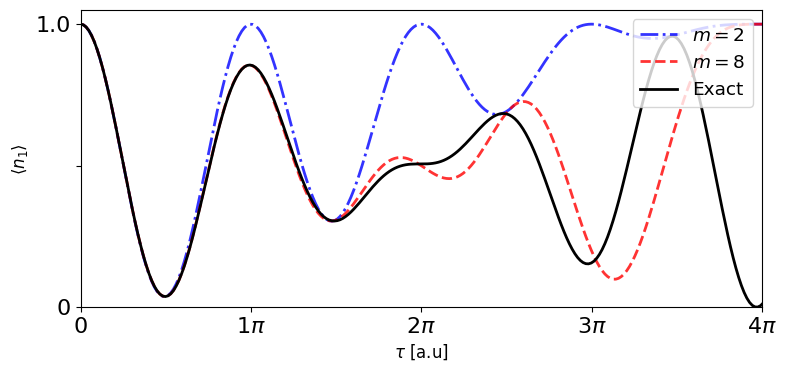

In [ ]:
# Plot state dynamics over one particular site
site = 0

xticks = np.linspace(0, 4 * np.pi, 5)
xtick_labels = [r'${}\pi$'.format(i) if i != 0 else '0' for i in range(5)]
yticks = [0, 0.5, 1.0]
ytick_labels = ['0', '', '1.0']

plt.figure(figsize=(8, 4))
plt.plot(
    times,
    evo_matrix_trot_1[:, site],
    "b-.",
    linewidth=2,
    label=rf"$m={trotter_steps_1}$",
    markerfacecolor="royalblue",
    alpha=0.8,
)
plt.plot(
    times,
    evo_matrix_trot_3[:, site],
    "r--",
    linewidth=2,
    label=rf"$m={trotter_steps_3}$",
    markerfacecolor="salmon",
    alpha=0.8,
)
# plt.plot(
#     times,
#     evo_matrix_trot_3[:, site],
#     "g--",
#     linewidth=2,
#     label=rf"$m={trotter_steps_3}$",
#     markerfacecolor="green",
#     alpha=0.8,
# )
plt.plot(
    times, n_evo_matrix_exact[:, site], "k-", linewidth=2, label="Exact", markerfacecolor="grey"
)
plt.xlabel(rf"$\tau$ [a.u]", fontsize=12)
plt.ylabel(rf"$\langle n_{site+1} \rangle$", fontsize=12)
plt.ylim([0.0, 1.05])
plt.xlim([0, 4*np.pi])
plt.legend(loc='upper right', framealpha=0.8, fontsize='small')
plt.tight_layout()
plt.xticks(xticks, xtick_labels) 
plt.yticks(yticks, ytick_labels)
plt.savefig('figures/JJ-kitaev/site1_1010_phase0_sweet_spot_trotterization.pdf')
plt.show()

### Trotter error

In [47]:
# Number of trotter steps
trotter_steps_error_1 = 15
trotter_steps_error_2 = 25
trotter_steps_error_3 = 50
# Calculate each number operator's expectation value at each time point
evo_matrix_trot_error_1 = trotter_evolution(H, n_is, initial_state, times, num_sites, trotter_steps_error_1)
evo_matrix_trot_error_2 = trotter_evolution(H, n_is, initial_state, times, num_sites, trotter_steps_error_2)
evo_matrix_trot_error_3 = trotter_evolution(H, n_is, initial_state, times, num_sites, trotter_steps_error_3)

100%|██████████| 500/500 [34:26<00:00,  4.13s/it]


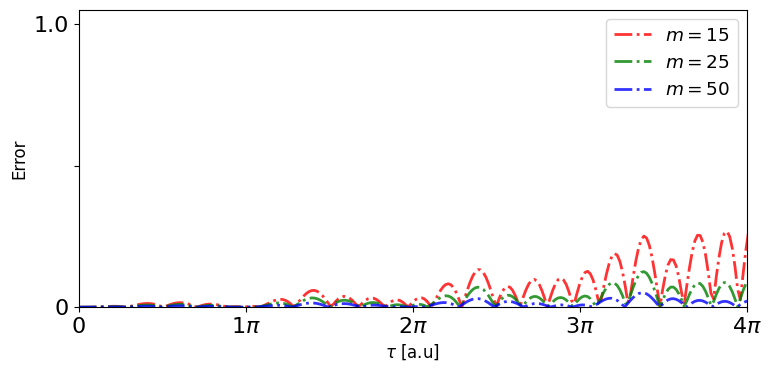

In [49]:
# Plot state dynamics over one particular site
site = 0

plt.figure(figsize=(8, 4))
plt.plot(
    times,
    np.abs(n_evo_matrix_exact[:, site]-evo_matrix_trot_error_1[:, site]),
    "r-.",
    linewidth=2,
    label=rf"$m={trotter_steps_error_1}$",
    markerfacecolor="salmon",
    alpha=0.8,
)
plt.plot(
    times,
    np.abs(n_evo_matrix_exact[:, site]-evo_matrix_trot_error_2[:, site]),
    "g-.",
    linewidth=2,
    label=rf"$m={trotter_steps_error_2}$",
    markerfacecolor="seagreen",
    alpha=0.8,
)
plt.plot(
    times,
    np.abs(n_evo_matrix_exact[:, site]-evo_matrix_trot_error_3[:, site]),
    "b-.",
    linewidth=2,
    label=rf"$m={trotter_steps_error_3}$",
    markerfacecolor="darkorange",
    alpha=0.8,
)

plt.xlabel(rf"$\tau$ [a.u]", fontsize=12)
plt.ylabel(rf"Error", fontsize=12)
plt.ylim([0.0, 1.05])
plt.xlim([0, 4*np.pi])
plt.legend(loc='upper right', framealpha=0.8, fontsize='small')
plt.tight_layout()
plt.xticks(xticks, xtick_labels) 
plt.yticks(yticks, ytick_labels)
plt.tight_layout()
plt.savefig('figures/JJ-kitaev/trotter-error-phase-pi.pdf')

plt.show()

### Generate circuit diagram

\documentclass[border=2px]{standalone}

\usepackage[braket, qm]{qcircuit}
\usepackage{graphicx}

\begin{document}
\scalebox{1.0}{
\Qcircuit @C=1.0em @R=1.0em @!R { \\
	 	\nghost{{q}_{0} :  } & \lstick{{q}_{0} :  } & \qw & \qw & \qw & \multigate{1}{\mathrm{R_{XX}}\,(\mathrm{2\pi})}_<<<{0} & \qw & \qw\\
	 	\nghost{{q}_{1} :  } & \lstick{{q}_{1} :  } & \qw & \multigate{1}{\mathrm{R_{XX}}\,(\mathrm{\frac{\pi}{2}})}_<<<{0} & \multigate{1}{\mathrm{R_{YY}}\,(\mathrm{\frac{\pi}{2}})}_<<<{0} & \ghost{\mathrm{R_{XX}}\,(\mathrm{2\pi})}_<<<{1} & \qw & \qw\\
	 	\nghost{{q}_{2} :  } & \lstick{{q}_{2} :  } & \multigate{1}{\mathrm{R_{XX}}\,(\mathrm{2\pi})}_<<<{0} & \ghost{\mathrm{R_{XX}}\,(\mathrm{\frac{\pi}{2}})}_<<<{1} & \ghost{\mathrm{R_{YY}}\,(\mathrm{\frac{\pi}{2}})}_<<<{1} & \qw & \qw & \qw\\
	 	\nghost{{q}_{3} :  } & \lstick{{q}_{3} :  } & \ghost{\mathrm{R_{XX}}\,(\mathrm{2\pi})}_<<<{1} & \qw & \qw & \qw & \qw & \qw\\
\\ }}
\end{document}


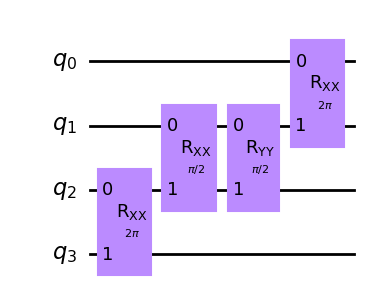

In [ ]:
from qiskit.opflow import PauliTrotterEvolution

def convert_U_trot_to_qc(U_trot):

    qc_trot = PauliTrotterEvolution().convert(U_trot)
    return (
        qc_trot.to_circuit().decompose()#.decompose()
    )  # add decompose methods so gates are not abstracted unitary blocks

from functions import compute_U_trot

num_sites = 4
tc = 0.5
eps = np.zeros(num_sites)
phi = pi
phiL = -phi / 2
phiR = phi / 2
delta_coef = 1
delta = np.array([delta_coef*np.exp(1j * phiL), delta_coef*np.exp(1j * phiR)])
t = np.ones(2)

H = compute_H_secondquant_normal(eps, tc, t, delta)
U1 = compute_U_trot(H, np.pi, 1)
qc = convert_U_trot_to_qc(U1)

latex_code = qc.draw("latex_source")
print(latex_code)
with open("circuits/2-site-coupling-circuit.tex", "w") as f:
    f.write(latex_code)
qc.draw("mpl")

In [ ]:
H

PauliSumOp(SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IIYY', 'IYYI', 'IXXI', 'IZII', 'ZIII', 'YYII'],
              coeffs=[ 2.  +0.j, -0.5 +0.j, -0.5 +0.j,  1.  +0.j,  0.25+0.j,  0.25+0.j,
 -0.5 +0.j, -0.5 +0.j,  1.  +0.j]), coeff=1.0)